In [56]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.axes as Axes
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
import json
from pandas.io.json import json_normalize
import matplotlib as matplotlib
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

**DATA PREPROCESSING:**

1) Firstly, The datasets in this exercise consists of several JSON objects that need to parsed.

In [2]:
#Below is the function which will parse the JSON values
def parse_df(csv_path=None,nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df_raw = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df_raw[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df_raw = df_raw.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df_raw

Let us load the training and test datasets using the function we just declared.

In [3]:
train_df_parsed = parse_df('C:/Users/Shubham/Desktop/DSF/HW3/all/train.csv')
test_df_parsed = parse_df("C:/Users/Shubham/Desktop/DSF/HW3/all/test.csv")

Let's take a look at the data types of the dataset that we are dealing with.

In [4]:
train_df_parsed.dtypes

channelGrouping                                      object
date                                                  int64
fullVisitorId                                        object
sessionId                                            object
socialEngagementType                                 object
visitId                                               int64
visitNumber                                           int64
visitStartTime                                        int64
device.browser                                       object
device.browserSize                                   object
device.browserVersion                                object
device.deviceCategory                                object
device.flashVersion                                  object
device.isMobile                                        bool
device.language                                      object
device.mobileDeviceBranding                          object
device.mobileDeviceInfo                 

WOW!! That are a lot of columns, let us see if we can drop some of them.

**DATA PREPROCESSING:**

2) If a column has only one constant value, it is not going to contribute towards the prediction. Let's check if we have such columns.

In [5]:
for col in train_df_parsed.columns:
    if len(train_df_parsed[col].unique()) == 1:
        print(col)

socialEngagementType
device.browserSize
device.browserVersion
device.flashVersion
device.language
device.mobileDeviceBranding
device.mobileDeviceInfo
device.mobileDeviceMarketingName
device.mobileDeviceModel
device.mobileInputSelector
device.operatingSystemVersion
device.screenColors
device.screenResolution
geoNetwork.cityId
geoNetwork.latitude
geoNetwork.longitude
geoNetwork.networkLocation
totals.visits
trafficSource.adwordsClickInfo.criteriaParameters


Looks like we have several of them. I am going to drop them all.

In [6]:
for col in train_df_parsed.columns:
    if len(train_df_parsed[col].unique()) == 1:
        train_df_parsed.drop(col,inplace=True,axis=1)

**DATA PREPROCESSING:**

3) A column might have two unique values but one of them might be NaN, again such columns are of no use . Let's check if we have such columns.

In [7]:
for col in train_df_parsed.columns:
    if len(train_df_parsed[col].unique()) == 2:
        print(col)
        print(train_df_parsed[col].unique())

device.isMobile
[False  True]
totals.bounces
['1' nan]
totals.newVisits
['1' nan]
trafficSource.adwordsClickInfo.isVideoAd
[nan False]
trafficSource.campaignCode
[nan '11251kjhkvahf']
trafficSource.isTrueDirect
[nan True]


There are a few. Let's drop them.

In [8]:
for col in train_df_parsed.columns:
    if len(train_df_parsed[col].unique()) == 2:
        if col != 'device.isMobile':
            train_df_parsed.drop(col,inplace=True,axis=1)

Now, Let's check for any NaN values in dataset.

In [9]:
train_df_parsed.isnull().sum()

channelGrouping                                      0
date                                                 0
fullVisitorId                                        0
sessionId                                            0
visitId                                              0
visitNumber                                          0
visitStartTime                                       0
device.browser                                       0
device.deviceCategory                                0
device.isMobile                                      0
device.operatingSystem                               0
geoNetwork.city                                      0
geoNetwork.continent                                 0
geoNetwork.country                                   0
geoNetwork.metro                                     0
geoNetwork.networkDomain                             0
geoNetwork.region                                    0
geoNetwork.subContinent                              0
totals.hit

There are several columns with NaN values, we will fill these NaNs appropriately.

**DATA PREPROCESSING:**

4) Since we already know that Tranaction Revenue is a numeric field, we will replace it's NaNs with zeroes.

In [10]:
train_df_parsed['totals.transactionRevenue'].fillna(0, inplace=True)
train_df_parsed.isnull().sum()

channelGrouping                                      0
date                                                 0
fullVisitorId                                        0
sessionId                                            0
visitId                                              0
visitNumber                                          0
visitStartTime                                       0
device.browser                                       0
device.deviceCategory                                0
device.isMobile                                      0
device.operatingSystem                               0
geoNetwork.city                                      0
geoNetwork.continent                                 0
geoNetwork.country                                   0
geoNetwork.metro                                     0
geoNetwork.networkDomain                             0
geoNetwork.region                                    0
geoNetwork.subContinent                              0
totals.hit

5) For the rest of the fields, I checked what kind of data they have and fill them with 'Not Set' if they have textual data, and with zeroes if otherwise.

In [12]:
train_df_parsed['trafficSource.adContent'].fillna('Not Set', inplace=True)
train_df_parsed['trafficSource.adwordsClickInfo.adNetworkType'].fillna('Not Set', inplace=True)
train_df_parsed['totals.pageviews'].fillna(0, inplace=True)
train_df_parsed['trafficSource.adwordsClickInfo.gclId'].fillna('Not Set', inplace=True)
train_df_parsed['trafficSource.adwordsClickInfo.page'].fillna('Not Set', inplace=True)
train_df_parsed['trafficSource.adwordsClickInfo.slot'].fillna('Not Set', inplace=True)
train_df_parsed['trafficSource.keyword'].fillna('Not Set', inplace=True)
train_df_parsed['trafficSource.referralPath'].fillna('Not Set', inplace=True)

**DATA PREPROCESSING:**

6) As seen in the begining, several fields are of Object data type. Some of these will be used for plotting data, which needs numeric data type.
I will convert the data types of these fields to int.

In [13]:
#Renaming and Changing data types of some columns which will be used for plotting

train_df_parsed.rename(index=str, columns={'totals.transactionRevenue': 'transactionRevenue'}, inplace =True)
train_df_parsed['transactionRevenue'] = train_df_parsed['transactionRevenue'].astype('int64')

train_df_parsed.rename(index=str, columns={'totals.hits': 'hits'}, inplace =True)
train_df_parsed['hits'] = train_df_parsed['hits'].astype('int64')

train_df_parsed.rename(index=str, columns={'totals.pageviews': 'pageviews'}, inplace =True)
train_df_parsed['pageviews'] = train_df_parsed['pageviews'].astype('int64')

In [14]:
#Also for test data, to maintain consitency in column names
test_df_parsed['totals.hits'].fillna(0, inplace=True)
test_df_parsed.rename(index=str, columns={'totals.hits': 'hits'}, inplace =True)
test_df_parsed['hits'] = test_df_parsed['hits'].astype('int64')
test_df_parsed['totals.pageviews'].fillna(0, inplace=True)
test_df_parsed.rename(index=str, columns={'totals.pageviews': 'pageviews'}, inplace =True)
test_df_parsed['pageviews'] = test_df_parsed['pageviews'].astype('int64')

In [15]:
#A Function that will be used throughout the notebook to plot between two features
def create_plot(feature1, feature2, size=[10,10]):
    plt.figure(figsize=(size))
    plot_df = train_df_parsed.groupby(feature1)[feature2].mean().reset_index()
    plot_df = plot_df.query(feature2+"!=0")
    plt.barh(plot_df[feature1], plot_df[feature2], align='center')

**Heatmap:**

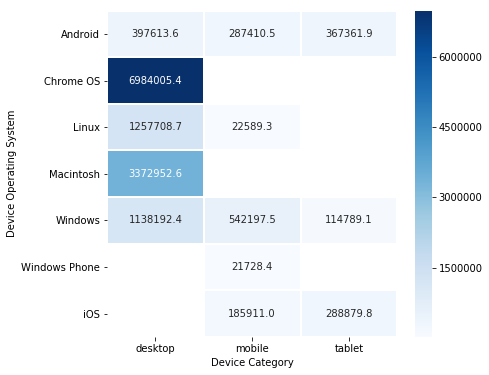

In [16]:
heat_df = train_df_parsed.groupby(['device.operatingSystem','device.deviceCategory'])['transactionRevenue'].mean().reset_index()
heat_df = heat_df.query('transactionRevenue!=0')
heat_df = heat_df.pivot_table(index=['device.operatingSystem'],columns=['device.deviceCategory'], values='transactionRevenue')
plt.figure(figsize=(6.5,6))
sns.heatmap(heat_df, annot=True, fmt=".1f",linewidths="1",cmap="Blues")
plt.xlabel('Device Category')
plt.ylabel('Device Operating System')
plt.show()

**Interpretation:** As we can see in the above Heatmap, A lot of the Revenue is being generated from people who are using ChromeOS and Android devices.
Which makes sense, as it is a known fact that the masses are broadly divided into Apple followers and Google followers.
So, it makes sense that people who are already Google customers will be the people who generate large revenues.
And it is also likely that people with Apple with most like stick to Apple products.

**Interesting Plot:**

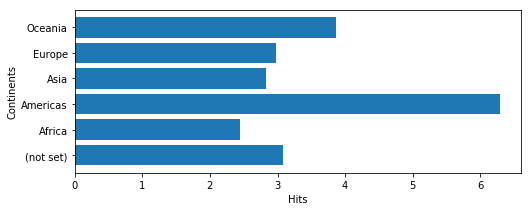

In [22]:
create_plot('geoNetwork.continent', 'hits',[8,3])
plt.xlabel('Hits')
plt.ylabel('Continents')
plt.show()

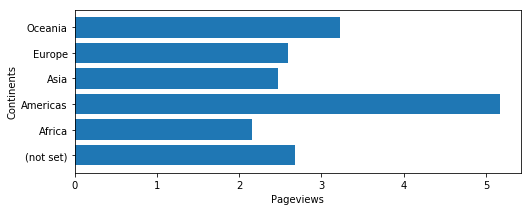

In [23]:
create_plot('geoNetwork.continent', 'pageviews',[8,3])
plt.xlabel('Pageviews')
plt.ylabel('Continents')
plt.show()

As we can see in the above two plots, most of the traffic to the store originated from America,
and the rest of the continents generate a reasonable amount of traffics.

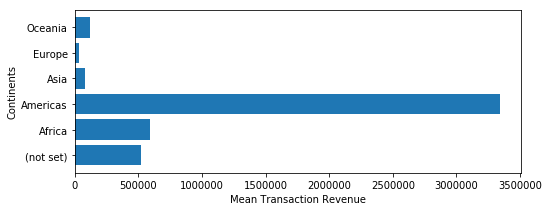

In [24]:
create_plot('geoNetwork.continent','transactionRevenue', [8,3])
plt.xlabel('Mean Transaction Revenue')
plt.ylabel('Continents')
plt.show()

But, as we plot the Continent Vs Mean Transaction Revenue bar plot, we observe that although the other continents genearated reasonable traffic to the store.
Only the traffic from America has generated comparable revenue.

**Clustering Data:** We will cluster the data based on some of the geographical features.(Continent and Subcontinent), and plot them against log of the revenue(for visualization purpose).

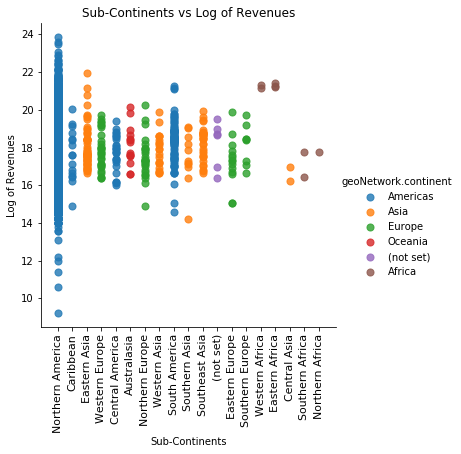

In [26]:
#Scatter plot of Subcontinents and Log of Revenues

train_df_parsed['transactionRevenue_log'] = np.log1p(train_df_parsed['transactionRevenue'].astype(float))
plot_df = train_df_parsed[['geoNetwork.continent','geoNetwork.subContinent','transactionRevenue_log']]
plot_df = plot_df.query('transactionRevenue_log!=0')
lm = sns.lmplot('geoNetwork.subContinent', 'transactionRevenue_log', 
           data=plot_df, 
           fit_reg=False, 
           hue="geoNetwork.continent",  
           scatter_kws={"marker": "D", 
                        "s": 50})
plt.title('Sub-Continents vs Log of Revenues')
plt.xlabel('Sub-Continents')
lm.set_xticklabels(rotation=90, size=11)
plt.ylabel('Log of Revenues')
plt.show()

**Interpretation:** We can see that in the American continent, North America generates more revenue than other subcontitnents. And in the Asian continent East Asia generates some of the higher revenues.

**Buying Score:** Let us list out all the points we have learnt so far:

1) If continent is America the revenue is high.

2) If continent is America the site graffic gets translated to revenue more often than other continents.

3) If the device being used runs ChromeOS and Android the chances of revenue are higher.

Apart from the above points, by intuition we know that if a person visits the store again and again the chances of him buying something are high.

Now, lets create a buying score keeping the above points in mind.

In [28]:
#First we define a funtion to normalize some of the data before we take them into consideration
def normalize_columns(df):
    df["hits"] = df["hits"].astype(float)
    df["hits"] = (df["hits"] - min(df["hits"])) / (max(df["hits"]) - min(df["hits"]))

    df["pageviews"] = df["pageviews"].astype(float)
    df["pageviews"] = (df["pageviews"] - min(df["pageviews"])) / (max(df["pageviews"]) - min(df["pageviews"]))
    return df 

In [29]:
train_df_parsed = normalize_columns(train_df_parsed)
#Again doing the same for test data to maintain consitency
test_df_parsed = normalize_columns(test_df_parsed)

In [63]:
#The function defining our buying score
def buying_score(row):
    if(row['geoNetwork.continent']=='America'):
        if(row['transactionRevenue']!=0):
            score = row.hits + row.pageviews + row.visitNumber
        else:
            score = 0
    else:
        if(row['transactionRevenue']!=0):
            score = row.visitNumber
        else:
            score = 0
    return score

In [64]:
#Creating a new column that contains scores for each visitor
train_df_parsed['score'] = train_df_parsed.apply(buying_score, axis=1)

In [69]:
#Now Let us get the top 10 users scored by our function.
train_df_parsed.sort_values('score', ascending=False)[['fullVisitorId','score']][0:10]

,fullVisitorId,score
574969,6944288019130180719,300.0
202743,0616530401183877867,299.0
131242,0205723721674321991,295.0
886691,7232030663207265797,245.0
755000,0514253309422836642,207.0
300722,8883600023735279403,192.0
381235,9324829089415258862,170.0
181544,2583318836591839554,167.0
755049,7811787934602942622,154.0
685994,1533016242418481907,151.0


**Creting Model:** First of all we need to encode all the categorical data for the purpose of modeling.

In [27]:
# Encoding Categorical Columns to create our model

from sklearn import preprocessing
# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "fullVisitorId", "sessionId",
            "device.browser", "device.deviceCategory", "device.isMobile",
            "device.operatingSystem", "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro", "geoNetwork.networkDomain",
            "geoNetwork.region", "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", "trafficSource.adwordsClickInfo.slot",
            "trafficSource.campaign", "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source"]
for col in cat_cols:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df_parsed[col].values.astype('str')) + list(test_df_parsed[col].values.astype('str')))
    train_df_parsed[col+"_code"] = lbl.transform(list(train_df_parsed[col].values.astype('str')))
    test_df_parsed[col+"_code"] = lbl.transform(list(test_df_parsed[col].values.astype('str')))

In [30]:
#Genearating Features and Spliting training data

features = [c for c in train_df_parsed.columns]
features.remove("transactionRevenue")
features.remove("transactionRevenue_log")
cat_cols = ["channelGrouping", "fullVisitorId", "sessionId",
            "device.browser", "device.deviceCategory", "device.isMobile",
            "device.operatingSystem", "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro", "geoNetwork.networkDomain",
            "geoNetwork.region", "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", "trafficSource.adwordsClickInfo.slot",
            "trafficSource.campaign", "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source"]
for col in cat_cols:
    features.remove(col)
    
X_train, X_test, y_train, y_test = train_test_split(train_df_parsed[features], train_df_parsed["transactionRevenue_log"], test_size=0.25, random_state=20)

In [ ]:
#Building the model ( We are going to use LGBM this time)

import lightgbm as lgb 

lgb_params = {"objective" : "regression", "metric" : "rmse",
              "num_leaves" : 50, "learning_rate" : 0.02, 
              "bagging_fraction" : 0.75, "feature_fraction" : 0.8, "bagging_frequency" : 9}
    
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_test, label=y_test)
model = lgb.train(lgb_params, lgb_train, 700, valid_sets=[lgb_val], early_stopping_rounds=150, verbose_eval=20)

In [32]:
#Finally let us predict the values and store the Output.

preds = model.predict(test_df_parsed[features], num_iteration=model.best_iteration)
test_df_parsed["PredictedLogRevenue"] = np.expm1(preds)
predictions = test_df_parsed.groupby("fullVisitorId").agg({"PredictedLogRevenue" : "sum"}).reset_index()
predictions["PredictedLogRevenue"] = np.log1p(predictions["PredictedLogRevenue"])
predictions["PredictedLogRevenue"] =  predictions["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
predictions.fillna(0, inplace=True)
predictions.to_csv("predictions.csv", index=False)

**Permutation Test:** I will run a series of permutation on the features of my model and calculat the RMSE for each permutation. I will then use a SciPy funtion stats.ttest_1samp() to get the p-value from the list of RMSE of each feature permuted.

In [41]:
#Let us save the RMSE of our model, as this will be used to generate P-value on task 7.

model_rmse = sqrt(mean_squared_error(y_test,pred))

In [ ]:
#Permutating the column values for some of our features and generating p-values using RMSE for each permutation for these features.

features_to_permute = ['visitNumber','hits','geoNetwork.continent_code','device.operatingSystem_code','trafficSource.source_code']

#We will save these p-values in a dictionary
p_values = dict()

#Before proceeding with permutation lets take a backup of the dataframe
train_df_backup = train_df_parsed

for feature in features_to_permute:
    feature_rmse = np.zeros(1000)
    for i in range(1000):
        train_df_parsed[feature] = np.random.permutation(train_df_parsed[feature])
        X_train, X_test, y_train, y_test = train_test_split(train_df_parsed[features], train_df_parsed["transactionRevenue_log"], test_size=0.25, random_state=20)
        lgb_params = {"objective" : "regression", "metric" : "rmse",
                  "num_leaves" : 50, "learning_rate" : 0.02, 
                  "bagging_fraction" : 0.75, "feature_fraction" : 0.8, "bagging_frequency" : 9}
    
        lgb_train = lgb.Dataset(X_train, label=y_train)
        lgb_val = lgb.Dataset(X_test, label=y_test)
        model = lgb.train(lgb_params, lgb_train, 700, valid_sets=[lgb_val], early_stopping_rounds=150, verbose_eval=20)
        pred = model.predict(X_test, num_iteration=model.best_iteration)
        feature_rmse[i] = sqrt(mean_squared_error(y_test,pred))
    
    #Replacing the shuffled value from our backup.
    train_df_parsed[feature] = train_df_backup[feature]
    
    #We use the below function to get the P-value.
    statistcs, pval = stats.ttest_1samp(feature_rmse, model_rmse)
    p_values[feature] = pval

As expected, continent and operating system are the most important features. On the other hand, traffic source does not matter as much.